# Traffic Flow Simulation

### Adapted by Watty from resources in [Think Complexity, 2nd edition by Allen Downey](https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap10.ipynb)

This notebook aims to present a simple explanatory model for traffic jams and how they arise. We'll be reusing a lot of code from the chapter 10 examples notebook from Think Complexity by Allen Downey, including the base `Cell2D` class you're likely to be familiar with by now, and will be building upon some of its other classes specifically implemented for our simulation. 

We can start off by importing the requisite libraries and functions that we'll be using. 

In [1]:
import os
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # used only for the color palette

from scipy.integrate import trapezoid

from time import sleep
from IPython.display import clear_output

The following functions are helper functions taken directly from https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/utils.py

In order for this notebook to be fully-functional on its own without importing additional files for dependencies beyond the previously imported libraries from PyPI, we're copying them into a block here. The purpose of each function is detailed in its docstring.


In [2]:
# dependency functions from https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/utils.py
# if you have utils.py in your working directory, you can directly import these items instead of copying them here

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

def legend(**options):
    """Draws a legend only if there is at least one labeled item.

    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html

    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like

    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties

    https://matplotlib.org/api/axes_api.html

    In addition, you can use `legend=False` to suppress the legend.

    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

def three_frame(world, n_seq, seed=17):
    """Draw three timesteps.
    
    world: object with step, loop, and draw
    n_seq: 3-tuple, number of steps before each draw
    seed: random seed for NumPy
    """
    np.random.seed(seed)
    plt.figure(figsize=(10, 4))

    for i, n in enumerate(n_seq):
        plt.subplot(1, 3, i+1)
        world.loop(n)
        world.draw()

    plt.tight_layout()

def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.

    args, kwds: same as for sns.color_palette

    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.

    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)

    palette = list(palette)
    if reverse:
        palette.reverse()

    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

Next, we'll need the basic `Cell2D` class for a 2-dimension cellular automata, taken directly from Allen Downey at https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/Cell2D.py

We'll also need the `draw_array` function for our `Cell2D` class's `draw` function to work properly, even though we won't be using it for this experiment. 

In [3]:
class Cell2D:
    """Parent class for 2-D cellular automata."""

    def __init__(self, n, m=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1):
        """Runs the given number of steps."""
        for i in range(iters):
            self.step()

    def draw(self, **options):
        """Draws the array.
        """
        draw_array(self.array, **options)

    # Here's how animate works
    # https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code
    # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.clear_output
    
    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.
        
        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step
            
        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

def draw_array(array, **options):
    """Draws the cells."""
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1, 
                        interpolation='none', 
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

Now the traffic simulation can start to be constructed one step at a time. We'll be starting with the necessary components to simulate the basic behaviour of a single driver in a single vehicle. 

To do this, we'll be using Downey's `Driver` class, used for building a driver object. For now, it has three attributes: location, stored as `loc`, speed, as `speed` (with a default value of 4 units of distance per unit of time), and a constant acceleration of one distance unit per measure of time squared, as expressed in `choose_acceleration` right now. We'll be improving this class later on, but we'll be starting off like this for a simple, easy-to-understand and easy-to-implement model. 

In [4]:
class Driver:
    # class for building a driver object
    # attributes: location, speed, acceleration

    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

We'll now need a `Highway` class to simulate a highway for our drivers to drive on. We'll be building upon the `Cell2D` class to do so, and we'll be using `driver` objects for our drivers. By default, when a new highway is initialized, it'll have 10 drivers on a 1,000 unit long highway. 

Aside from the attributes described in the docstring in the `__init__` function, we also have the following three parameters declared at the beginning of a `Highway` class object:

- `max_acc` and `min_acc` represent the maximum and minimum permitted acceleration of each driver on the highway, and
- `speed_limit` represents the maximum permitted speed on the highway. This speed limit cannot be exceeded by any drivers. 


In [5]:
# code and comments from Think Complexity, 2nd Edition

class Highway(Cell2D):

    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > dist:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

Now that we have the basic tools we need for a simulation, let's take a look at how traffic jams arise by creating a new `Highway` object with 30 cars, and an individual speed variability of 2%, by passing the arguments `30` and `eps=0.02`. We'll also be animating this highway for 50 frames, with a 0.2 second delay between each frame of the animation. You'll notice that when the difference in speed between adjacent drivers invariably leads to traffic, red triangles will demarcate where current traffic jam events are occurring. 

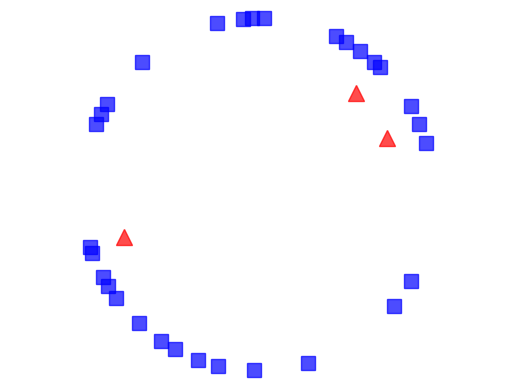

In [6]:
# code written by Downey, annotated by Watty
highway = Highway(30, eps=0.02)
# creates a highway with 30 drivers, each with a speed variability of 2% (eps=0.02)
highway.animate(frames=50, interval=0.2)
# animates the highway for 50 frames, with a 0.2 second delay between frames

We can do that again, but this time, rather than studying the animation, let's use `three_Frame` from the previously defined helper functions to draw three consecutive frames from when a traffic jam arises in order to examine traffic behaviour one step at a time. 

We'll initialize a fresh `Highway` object, pass it to `three_Frame`, and by manipulating the second and third arguments, we can see different frames of our specific highway. Note that the second argument to be passed is a 3-tuple, but can also accept a list with length 3, containing the first frame we want, then the distances between each following frame. The third argument, `seed`, is used for controlling the simulation. All tests with the same seed should yield the same results, but changing the seed will permit us to examine different cases. 

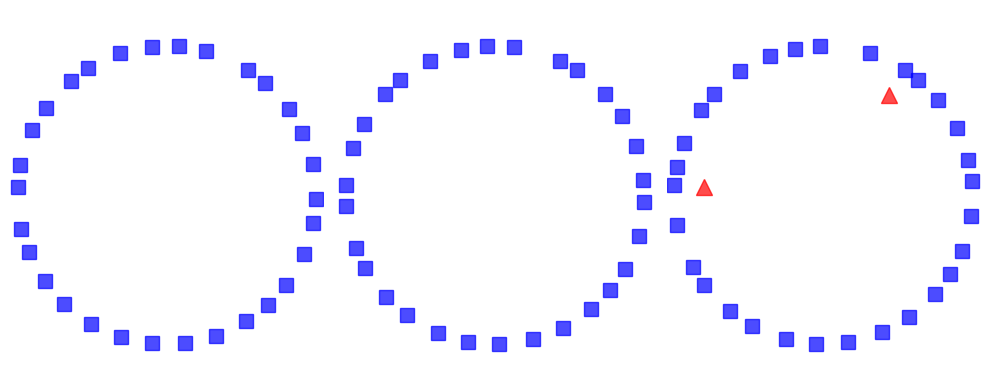

In [7]:
highway = Highway(30, eps=0.02)
# taken from Think Complexity, 2nd Edition, modified slightly 

three_frame(highway, (16, 1, 1), seed=24) # list modified back to a 3-tuple, seed changed to 24 from 22

# plt.show() not needed, already called in three_frame()

Downey provides us with a the `run_simulation` function, which takes an `eps` argument for variability in speed between drivers for a given simulation run, and an `iters` argument that determines the number of iterations or timesteps, with the default value being 100 iterations. This function returns a 2-tuple of the number of cars and the average distance travelled per car divided by the number of iterations run, which can be interpreted as the average (mean) speed per car in distance units over time units. 

In [8]:
def run_simulation(eps, constructor=Driver, iters=100):
    # code by Downey, annotated by Watty
    # runs the simulation with the params eps and iters, with a default of 100 iterations
    # returns a 2-tuple with number of cars n and the average speed of the cars
    # n: number of drivers
    # eps: variability in speed

    res = [] # empty list for results
    for n in range(5, 100, 5): # range from 5 to 100 cars, incrementing by 5
        highway = Highway(n, eps=eps, constructor=constructor) # create a highway with n cars
        for i in range(iters): # for each iteration
            highway.step() # step the simulation

        highway.set_odometers() # set the odometers to record distance travelled
        for i in range(iters): # for each iteration
            highway.step() # step the simulation

        res.append((n, highway.read_odometers() / iters)) # append the number of cars and the average speed to the results list
    
    return np.transpose(res)

Let's make use of `run_simulation`, as demonstrated by Downey, to quickly generate a figure showing the relationship between `eps`, which is our variable being changed, and the average speed of drivers on a given simulated highway. 

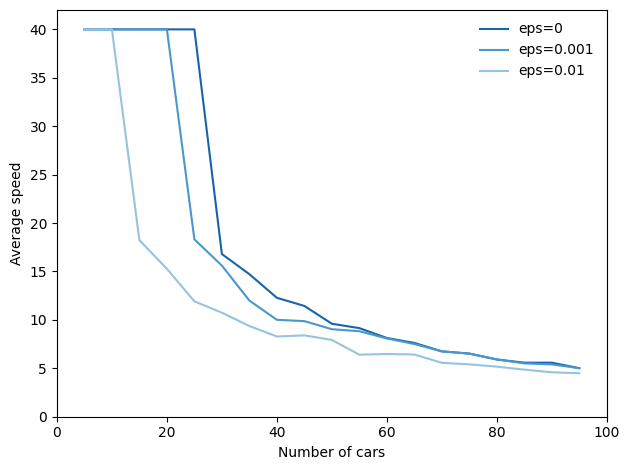

In [12]:
# code by Downey, annotated by Watty
np.random.seed(20) # fixes seed for reproducibility
set_palette('Blues', 4, reverse=True) # just color stuff for plotting on a graph

for eps in [0.0, 0.001, 0.01]: # for each value of eps
    xs, ys = run_simulation(eps) # run the simulation
    plt.plot(xs, ys, label='eps=%g' % eps) # plot the results
    
decorate(xlabel='Number of cars', # label the graph
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42]) # axes limits

# plt.show('figs/chap10-2')

We can now see that while traffic will always end up slowing down as the number of cars increases, a greater variance in speed between drivers will result in more frequent traffic jams which then results in a decreased average travelling speed for all drivers on the same highway. While a more heavily travelled and more congested freeway will always result in slowdowns, a mere 1% increase in speed variance results in a noticeable difference in average speeds at the upper end of the graph. The effects of `eps` are even more noticeable when the highway isn't as populated: for the simulation with a speed variance of 1%, fewer than 20 cars can remain on the highway in order to keep travelling at the maximum permitted speed, whereas with no variance, almost 30 cars can travel on the highway simultaneously. 

Now that we have a basic understanding of traffic flow simulations, let's expand upon what Downey's provided for us by further developing the `Driver` class into a `BetterDriver` class that improves upon some behavioural aspects. We know that variance between driver speeds is (at least in our brief experiment here) the culprit responsible for causing traffic jams - so how do we reduce the likelihood of traffic jams spontaneously occurring?

One approach might be to ensure that there's a way to provide a buffer for our drivers' speeds, and the distance between them. To do this, we'll improve upon the very basic `choose_acceleration` class method that was provided in Downey's `Driver` class. 

In [35]:
class BetterDriver(Driver): # inherits from Driver

    def choose_acceleration(self, dist): # overrides our old choose_acceleration method where we had to manually choose acceleration
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        # calculate the desired safe distance as a function of speed, specifically, 2 time units x the speed we're travelling at
        safe_distance = 2 * self.speed 
        # calculate the difference between the current distance and the safe distance
        diff = safe_distance - dist
        # if the current distance is greater than the safe distance, accelerate at max_acc
        # max_acc derived from the Highway class
        if diff <= 0:
            acc = Highway.max_acc
        # if the current distance is less than the safe distance, decelerate linearly
        else:
            acc = Highway.max_acc * (diff / safe_distance)
        return acc

Our `BetterDriver` class now has a more fleshed-out `choose_acceleration` function, which accounts for the distance between the current driver and the driver in front of them. By default, the safe distance is set to 2 time units multiplied by the speed the driver is travelling at, in units of distance over time. As an example, for a driver travelling at 10m/s, the safe distance would be 20 m. This can be changed by changing the `safe_distance` line in the `choose_acceleration` function in the `BetterDriver` class. 

We'll once again be borrowing a piece of code written by Downey to compare the behaviour of our `BetterDriver` class against the original `Driver` class when travelling on the same highway. While Downey has the code on its own, we'll be reusing the code several times again later on, so we might as well change it up a little by wrapping it into a nifty little function here!

Driver 1512.925
BetterDriver 1033.2144117587075


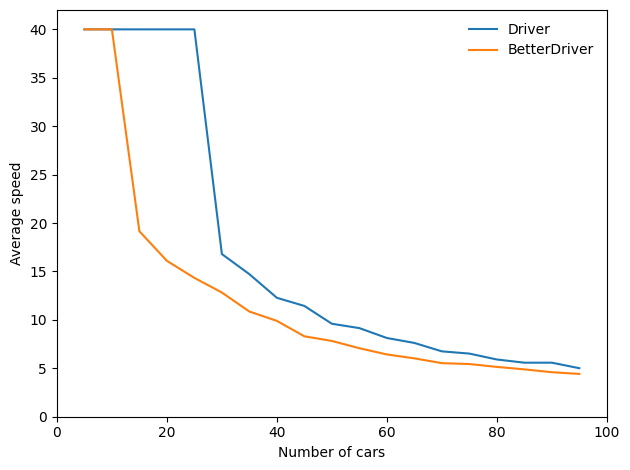

In [45]:
def compare_drivers(driverA, driverB):
    # code by Downey, annotated by Watty
    for constructor in [driverA, driverB]: # for each constructor, Driver and BetterDriver
        xs, ys = run_simulation(eps=0.0, constructor=constructor)
        plt.plot(xs, ys, label=constructor.__name__) # plot the results
        print(constructor.__name__, trapezoid(ys, xs)) # print the name of the constructor and the area under the curve
        
    decorate(xlabel='Number of cars', # basic graph labelling stuff
                    ylabel='Average speed',
                    xlim=[0, 100], ylim=[0, 42])
    
compare_drivers(Driver, BetterDriver)

We can see that the new `BetterDriver` class, with its slightly more complex `choose_acceleration` class method, results in even slower travel than the original, mostly due to the safer driving habits of our new drivers. (Seriously, how were the old fellas even licensed, always flooring it until they hit the speed limit?) Let's quickly use `run_simulation` to compare variance in `eps` across `BetterDrivers`, like we did previously with our original `Driver`s!

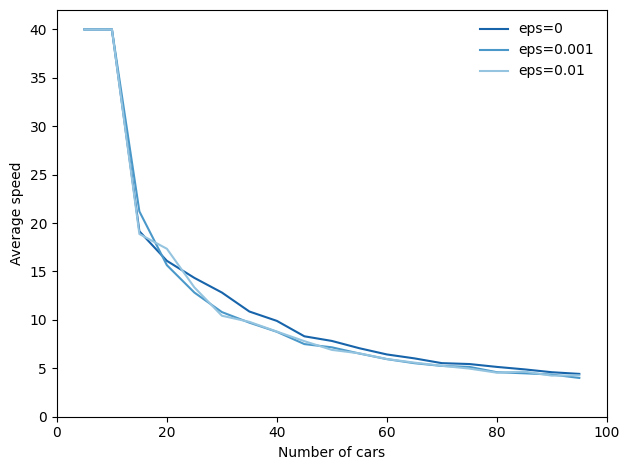

In [40]:
# code mostly copied from above, with slight modifications to arguments pass to run_simulation
np.random.seed(20) # fixes seed for reproducibility
set_palette('Blues', 4, reverse=True) # just color stuff for plotting on a graph

for eps in [0.0, 0.001, 0.01]: # for each value of eps
    xs, ys = run_simulation(eps, constructor=BetterDriver) # run the simulation using the BetterDriver constructor
    plt.plot(xs, ys, label='eps=%g' % eps) # plot the results
    
decorate(xlabel='Number of cars', # label the graph
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42]) # axes limits

Well, our `BetterDriver`s are definitely slower drivers. That's because they actually know what deceleration is now, though, and we can see that despite being slower, they show more consistent results when it comes to their average speed despite a spread in tested `eps` values - the same spread we tested above for our regular `Driver`s. The plots for `eps` values for no variance, 0.1% variance, and 1% variance now almost continuously overlap each other on the graph, with no `eps` variance doing only *slightly* better as the number of cars increased. 

This can be attributed to the fact that the original `Driver`s had constant acceleration, meaning that they would always try to accelerate at a fixed rate of one unit of distance per distance of time squared, regardless of the situation they were in, until they bumped into the car in front or hit the speed limit. In contrast, our `BetterDriver`s are significantly more cautious, willing to decelerate as they approach the car in front of them, which results in their speed being reduced across the board. However, this is the same factor that increases their consistency and reduces their crash likelihood. Despite the slower speed, there will be fewer bottlenecks with our `BetterDriver`s and traffic will overall be somewhat smoother. We can test this again by tweaking the `safe_distance` value in our `BetterDriver`'s `choose_acceleration` method to be lower, and the speed of travel should increase in turn. 

In [43]:
class BetterDriver50(Driver): # inherits from Driver

    def choose_acceleration(self, dist): # overrides our old choose_acceleration method where we had to manually choose acceleration
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        # calculate the desired safe distance as a function of speed, specifically, 2 time units x the speed we're travelling at
        safe_distance = 1.5 * self.speed 
        # calculate the difference between the current distance and the safe distance
        diff = safe_distance - dist
        # if the current distance is greater than the safe distance, accelerate at max_acc
        # max_acc derived from the Highway class
        if diff <= 0:
            acc = Highway.max_acc
        # if the current distance is less than the safe distance, decelerate linearly
        else:
            acc = Highway.max_acc * (diff / safe_distance)
        return acc

Let's once again use `compare_drivers` to quickly visualize the difference between `BetterDriver`, with its acceptable driver distance of 2 x speed, and `BetterDriver50`, with its acceptable driver distance of 1.5 x speed.

BetterDriver 1033.2144117587075
BetterDriver50 1269.4629553251657


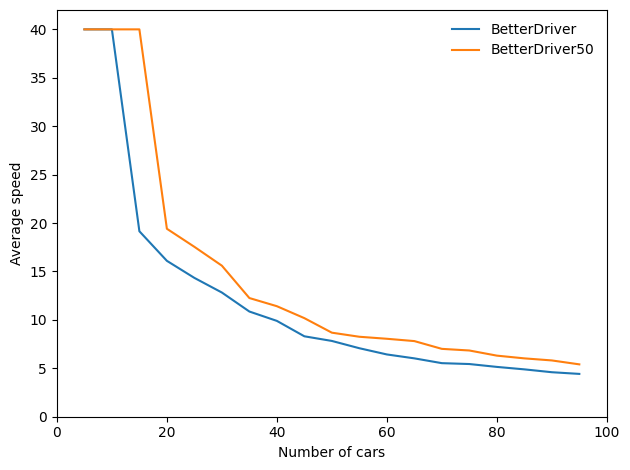

In [46]:
compare_drivers(BetterDriver, BetterDriver50)

From these results, we can indeed confirm as hypothesized before that as the permissibile safe distance between cars decreases, the average speed of travel increases. However, we must note that as in a real-world situation, as the buffer distance between vehicles decreases, drivers have less time to react and hit the brakes, as well as less braking distance to reach a full stop if something were to happen to the car travelling in front of them, so it is suggested that some safe minimum distance between cars be maintained - as is often taught in driver's ed. 

We could also develop the `choose_acceleration` class method as well as the `BetterDriver` class in different manners in order to account for the aforementioned reaction time and braking distance as well, but I'll leave those for future exercises! Let's close out this notebook with one last look at `BetterDriver50` to ensure that it, much like `BetterDriver`, is more consistent than the initial `Driver` class as well.

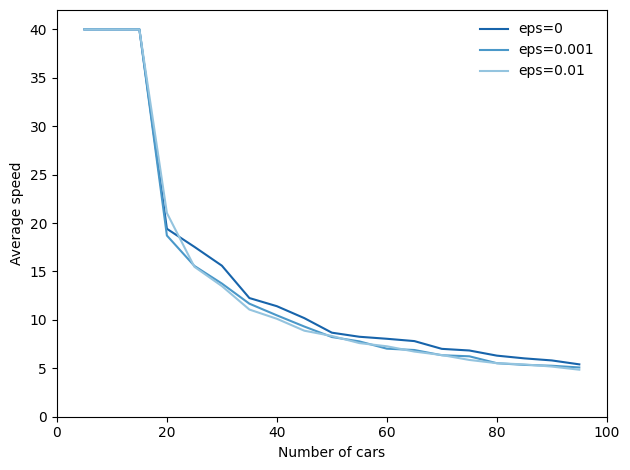

In [47]:
# code mostly copied from above, with slight modifications to arguments pass to run_simulation
np.random.seed(20) # fixes seed for reproducibility
set_palette('Blues', 4, reverse=True) # just color stuff for plotting on a graph

for eps in [0.0, 0.001, 0.01]: # for each value of eps
    xs, ys = run_simulation(eps, constructor=BetterDriver50) # run the simulation using the BetterDriver constructor
    plt.plot(xs, ys, label='eps=%g' % eps) # plot the results
    
decorate(xlabel='Number of cars', # label the graph
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42]) # axes limits

And sure enough, just like `BetterDriver`, `BetterDriver50` is also more consistent (if slightly slower) than our original `Driver` class implemented by Allen Downey, and should hypothetically result in fewer accidents and fewer spontaneous traffic jams, at a minor cost to average travel speed. 

I hope this has been an informative look at some of the links between driver behaviour and traffic jams!